tensor([[0.]])
tensor(32.4803, grad_fn=<MulBackward0>)
tensor([[0.0050]])
tensor(19.6048, grad_fn=<MulBackward0>)
tensor([[0.0100]])
tensor(11.0494, grad_fn=<MulBackward0>)
tensor([[0.0150]])
tensor(5.4565, grad_fn=<MulBackward0>)
tensor([[0.0200]])
tensor(2.1056, grad_fn=<MulBackward0>)


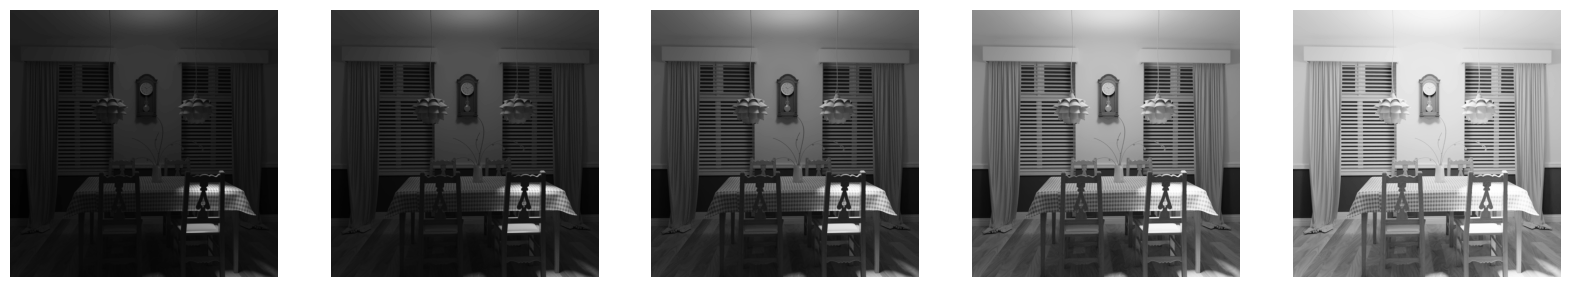

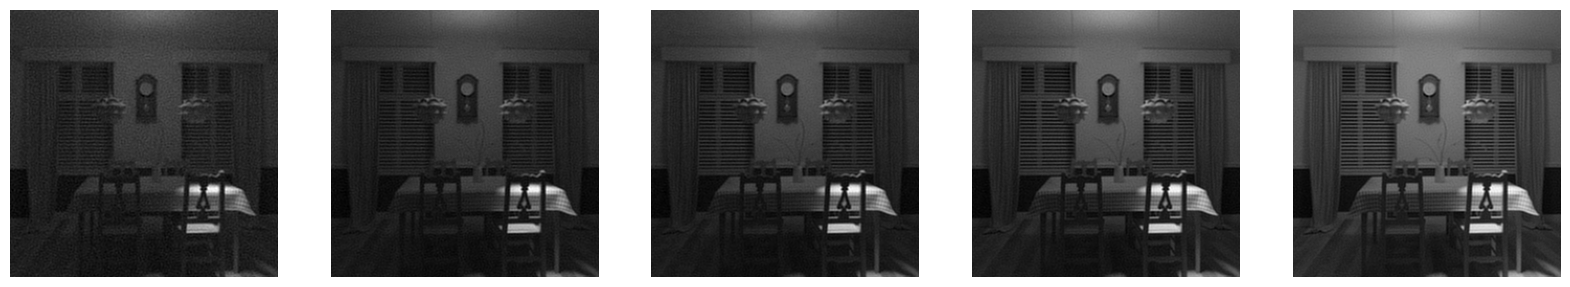

In [3]:
'''
Test hdr_model
'''

from hdr_model import PLFourierNet, HDRDataset
from torch.utils.data import DataLoader
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

ckpt_path = "hdr_model/last.ckpt"
model = PLFourierNet(pos_embed=False)
for k,v in torch.load(ckpt_path, map_location='cpu')['state_dict'].items():
    model.state_dict()[k].copy_(v)
dataset = HDRDataset(side_length=256)
loader = DataLoader(dataset, batch_size=1, pin_memory=True)
ys_pred = []
ys = []
zs = np.arange(0.0, 0.05, 0.005)
for i, batch in enumerate(loader):
    x, y, _ = batch
    z = torch.tensor([[zs[i]]]).float().to(model.device)
    print(z)
    x = x.float().to(model.device)
    y = y.float().to(model.device)
    z = z.float().to(model.device)
    _ , y_pred = model(x, z)
    loss = ((y_pred - y) ** 2).mean()
    psnr = -10*torch.log10(loss)
    print(psnr)
    ys_pred.append(y_pred[0].detach().cpu().numpy().reshape(256,256))
    ys.append(y[0].detach().cpu().numpy().reshape(256,256))

length = len(dataset)
fig1, axs1 = plt.subplots(1, length, figsize=(length * 4, 4))
fig2, axs2 = plt.subplots(1, length, figsize=(length * 4, 4))

for i, (y_, y_pred_) in enumerate(zip(ys, ys_pred)):
    y_ = np.array(Image.open(dataset.images[i]).convert("L"))
    axs1[i].imshow(y_ , cmap='gray')
    axs1[i].axis("off")
    axs2[i].imshow(y_pred_,  cmap='gray')
    axs2[i].axis("off")



In [5]:
'''
test_hdr_model with slide bar
'''

import torch
import cv2
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from hdr_model_mul import PLFourierNet

def show_image(z):
    assert z>=0 and z<=5
    ckpt_path = "hdr_model/last.ckpt"
    model = PLFourierNet(pos_embed=False)
    for k,v in torch.load(ckpt_path, map_location='cpu')['state_dict'].items():
        model.state_dict()[k].copy_(v)
    side_length = 256
    x = torch.stack(
            torch.meshgrid(
                [
                    torch.linspace(-1.0, 1.0, side_length),
                    torch.linspace(-1.0, 1.0, side_length),
                ]
            ),
            dim=-1,
        ).view(-1, 2).to(model.device)
    z = torch.tensor([[z]]).float().to(model.device)
    _ , y_pred = model(x, z)
    y_pred = y_pred[0].detach().cpu().numpy().reshape(256,256)
    plt.imshow(y_pred)
    plt.show()

contrast_slider = widgets.FloatSlider(value=0.001, min=0.0, max=0.06, step=0.001, description='latent')
# display(contrast_slider)
widgets.interactive(show_image, z=contrast_slider)

interactive(children=(FloatSlider(value=0.001, description='latent', max=0.06, step=0.001), Output()), _dom_cl…

In [ ]:
'''
test hdr_model with concatentation of [x,y,z]
'''

import torch
import cv2
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from hdr_model_xyz import PLFourierNet

def show_image():
    ckpt_path = "hdr_xyz/last-v1.ckpt"
    model = PLFourierNet()
    for k,v in torch.load(ckpt_path, map_location='cpu')['state_dict'].items():
        model.state_dict()[k].copy_(v)
    side_length = 256
    x = torch.stack(
            torch.meshgrid(
                [
                    torch.linspace(-1.0, 1.0, side_length),
                    torch.linspace(-1.0, 1.0, side_length),
                    torch.linspace(0.01, 0.02, 5),
                ]
            ),
            dim=-1,
        ).view(-1,5,3).transpose(0,1)
    y_pred = model(x)
    print(y_pred.shape)
    y_pred = (y_pred-y_pred.min())/(y_pred.max()-y_pred.min())
    for y in y_pred:
        y = y.detach().cpu().numpy().reshape(side_length, side_length,3)
        plt.imshow(y)
        plt.show()

show_image()

torch.Size([5, 65536, 3])


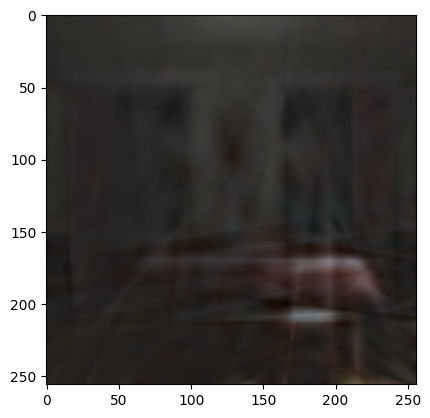

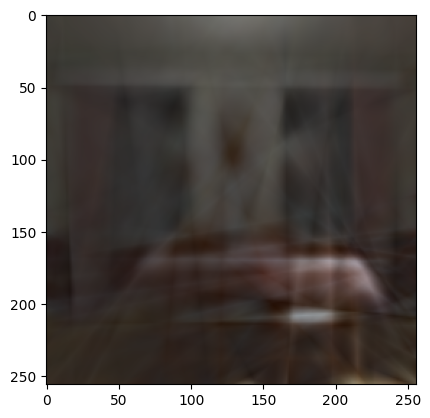

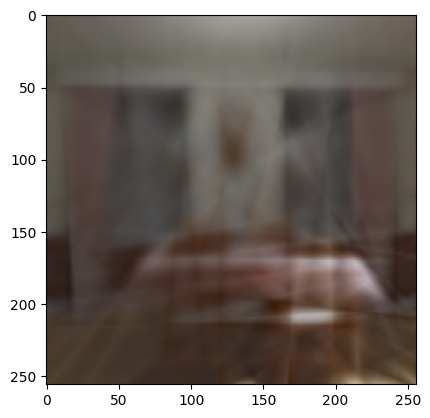

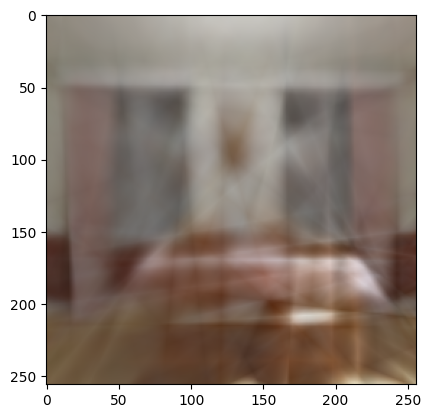

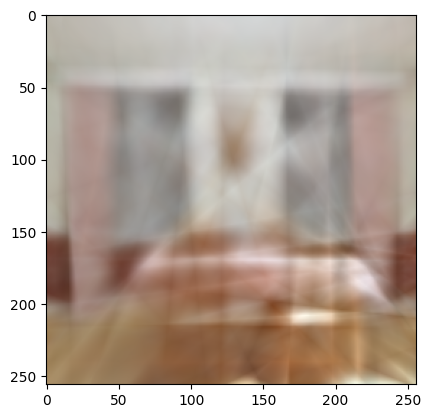

In [7]:
'''
test hdr_model with relu activation
'''

import torch
import cv2
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from hdr_model_relu import PLFourierNet

def show_image():
    ckpt_path = "hdr_relu/last-v1.ckpt"
    model = PLFourierNet()
    for k,v in torch.load(ckpt_path, map_location='cpu')['state_dict'].items():
        model.state_dict()[k].copy_(v)
    side_length = 256
    x = torch.stack(
            torch.meshgrid(
                [
                    torch.linspace(-1.0, 1.0, side_length),
                    torch.linspace(-1.0, 1.0, side_length),
                    torch.linspace(0.00, 0.04, 5),
                ]
            ),
            dim=-1,
        ).view(-1,5,3).transpose(0,1)
    y_pred = model(x)
    print(y_pred.shape)
    y_pred = (y_pred-y_pred.min())/(y_pred.max()-y_pred.min())
    for y in y_pred:
        y = y.detach().cpu().numpy().reshape(side_length, side_length,3)
        plt.imshow(y)
        plt.show()

show_image()